In [1]:
from keras import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Reshape, Input, BatchNormalization, MaxPooling2D, LeakyReLU, Add
from keras import backend as K
import tensorflow as tf
import numpy as np
from keras.applications import InceptionV3, ResNet50V2, InceptionResNetV2
from keras.optimizers import SGD
import json
import copy
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw
import io

BASE_PATH = os.path.join('.', 'drive', 'My Drive', 'IZ*Net')

In [2]:
ANCHOR_SIZES = np.array([[1, 1], [1, 1.15]])

def getHelperFunctions(gridSize):
  def getXOffsets(theGridSize): return lambda: K.expand_dims(K.arange(theGridSize, dtype=tf.float64))
  def getYOffsets(theGridSize): return lambda: K.expand_dims(K.reshape(K.arange(theGridSize, dtype=tf.float64), (theGridSize, 1)))
  return (getXOffsets(gridSize), getYOffsets(gridSize))

def yoloLoss(yTrueIn, yPredIn):
  LAMBDA_COORD = 5
  LAMBDA_NOOBJ = 0.5
  (BATCH_SIZE, N_ROWS, _, _, _) = yTrueIn.shape 

  yTrue = K.cast(yTrueIn, 'float64')
  yPred = K.cast(yPredIn, 'float64')

  (getXOffsets, getYOffsets) = getHelperFunctions(N_ROWS)

  yTrueXRealCoords = K.expand_dims(yTrue[...,1] + getXOffsets())
  yTrueYRealCoords = K.expand_dims(yTrue[...,2] + getYOffsets())
  yTrueWithRealCoords = K.concatenate([K.expand_dims(yTrue[...,0]), yTrueXRealCoords, yTrueYRealCoords, K.expand_dims(yTrue[...,3]), K.expand_dims(yTrue[...,4])])

  yPredCRealCoords = K.expand_dims(tf.sigmoid(yPred[...,0]))
  yPredXRealCoords = K.expand_dims(tf.sigmoid(yPred[...,1]) + getXOffsets())
  yPredYRealCoords = K.expand_dims(tf.sigmoid(yPred[...,2]) + getYOffsets())
  yPredWRealCoords = K.expand_dims(K.exp(yPred[...,3]) * ANCHOR_SIZES[...,0])
  yPredHRealCoords = K.expand_dims(K.exp(yPred[...,4]) * ANCHOR_SIZES[...,1])
  yPredWithRealCoords = K.concatenate([yPredCRealCoords, yPredXRealCoords, yPredYRealCoords, yPredWRealCoords, yPredHRealCoords])

  indicatorMask = K.expand_dims(yTrueWithRealCoords[...,0])
  xyLoss = K.sum(K.square((yTrueWithRealCoords[...,1:3] - yPredWithRealCoords[...,1:3]) * indicatorMask))
  whLoss = K.sum(K.square((K.sqrt(yTrueWithRealCoords[...,3:5]) - K.sqrt(yPredWithRealCoords[...,3:5])) * indicatorMask))

  topLeftCoordOfIntersect = K.maximum(yPredWithRealCoords[...,1:3] - (yPredWithRealCoords[...,3:5] / 2.), yTrueWithRealCoords[...,1:3] - (yTrueWithRealCoords[...,3:5] / 2.))
  bottomRightCoordOfIntersect = K.minimum(yPredWithRealCoords[...,1:3] + (yPredWithRealCoords[...,3:5] / 2.), yTrueWithRealCoords[...,1:3] + (yTrueWithRealCoords[...,3:5] / 2.))
  widthAndHeightOfIntersect = K.maximum(bottomRightCoordOfIntersect - topLeftCoordOfIntersect, 0)
  intersectionAreas = widthAndHeightOfIntersect[...,0] * widthAndHeightOfIntersect[...,1]
  encodingAreas = yPredWithRealCoords[...,3] * yPredWithRealCoords[...,4]
  boundingBoxAreas = yTrueWithRealCoords[...,3] * yTrueWithRealCoords[...,4]
  unionAreas = encodingAreas + boundingBoxAreas - intersectionAreas
  IOUScores = tf.truediv(intersectionAreas, unionAreas)

  noObjCLoss = LAMBDA_NOOBJ * (K.sum(K.square(K.expand_dims(yPredWithRealCoords[...,0]) * (1. - indicatorMask))) + K.sum(K.square(K.expand_dims(1 - yPredWithRealCoords[...,0]) * indicatorMask)))
  objCLoss = K.sum(K.square(K.expand_dims(yTrueWithRealCoords[...,0] - IOUScores) * indicatorMask))

  return tf.truediv(noObjCLoss + objCLoss + LAMBDA_COORD * (xyLoss + whLoss), BATCH_SIZE)

def yoloAccuracy(yTrueIn, yPredIn):
  (_, N_ROWS, _, _, _) = yTrueIn.shape 

  yTrue = K.cast(yTrueIn, 'float64')
  yPred = K.cast(yPredIn, 'float64')

  (getXOffsets, getYOffsets) = getHelperFunctions(N_ROWS)

  yTrueXRealCoords = K.expand_dims(yTrue[...,1] + getXOffsets())
  yTrueYRealCoords = K.expand_dims(yTrue[...,2] + getYOffsets())
  yTrueWithRealCoords = K.concatenate([K.expand_dims(yTrue[...,0]), yTrueXRealCoords, yTrueYRealCoords, K.expand_dims(yTrue[...,3]), K.expand_dims(yTrue[...,4])])

  yPredCRealCoords = K.expand_dims(tf.sigmoid(yPred[...,0]))
  yPredXRealCoords = K.expand_dims(tf.sigmoid(yPred[...,1]) + getXOffsets())
  yPredYRealCoords = K.expand_dims(tf.sigmoid(yPred[...,2]) + getYOffsets())
  yPredWRealCoords = K.expand_dims(K.exp(yPred[...,3]) * ANCHOR_SIZES[...,0])
  yPredHRealCoords = K.expand_dims(K.exp(yPred[...,4]) * ANCHOR_SIZES[...,1])
  yPredWithRealCoords = K.concatenate([yPredCRealCoords, yPredXRealCoords, yPredYRealCoords, yPredWRealCoords, yPredHRealCoords])

  topLeftCoordOfIntersect = K.maximum(yPredWithRealCoords[...,1:3] - (yPredWithRealCoords[...,3:5] / 2.), yTrueWithRealCoords[...,1:3] - (yTrueWithRealCoords[...,3:5] / 2.))
  bottomRightCoordOfIntersect = K.minimum(yPredWithRealCoords[...,1:3] + (yPredWithRealCoords[...,3:5] / 2.), yTrueWithRealCoords[...,1:3] + (yTrueWithRealCoords[...,3:5] / 2.))
  widthAndHeightOfIntersect = K.maximum(bottomRightCoordOfIntersect - topLeftCoordOfIntersect, 0)
  intersectionAreas = widthAndHeightOfIntersect[...,0] * widthAndHeightOfIntersect[...,1]
  encodingAreas = yPredWithRealCoords[...,3] * yPredWithRealCoords[...,4]
  boundingBoxAreas = yTrueWithRealCoords[...,3] * yTrueWithRealCoords[...,4]
  unionAreas = encodingAreas + boundingBoxAreas - intersectionAreas
  IOUScores = tf.truediv(intersectionAreas, unionAreas)

  return tf.truediv(K.sum(IOUScores * yPredWithRealCoords[...,0] * yTrueWithRealCoords[...,0]), K.sum(yTrueWithRealCoords[...,0]))

In [3]:
def Conv(XInput, filters, kernel_size, strides):
  X = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(XInput)
  X = BatchNormalization()(X)
  X = LeakyReLU(0.1)(X)
  return X

def Residual(XInput, filters):
  XBranch = Conv(XInput, filters=filters, kernel_size=1, strides=1)
  XBranch = Conv(XBranch, filters=filters * 2, kernel_size=3, strides=1)
  X = Add()([XInput, XBranch])
  return X

def network():
  X_input = Input((416, 416, 3))

  X = Conv(X_input, filters=32, kernel_size=3, strides=1)
  X = Conv(X, filters=64, kernel_size=3, strides=2)
  X = Residual(X, filters=32)
  X = Conv(X, filters=128, kernel_size=3, strides=2)
  X = Residual(X, filters=64)
  X = Residual(X, filters=64)
  X = Conv(X, filters=256, kernel_size=3, strides=2)
  X = Residual(X, filters=128)
  X = Residual(X, filters=128)
  X = Residual(X, filters=128)
  X = Residual(X, filters=128)
  X = Residual(X, filters=128)
  X = Residual(X, filters=128)
  X = Residual(X, filters=128)
  X = Residual(X, filters=128)
  X = Conv(X, filters=512, kernel_size=3, strides=2)
  X = Residual(X, filters=256)
  X = Residual(X, filters=256)
  X = Residual(X, filters=256)
  X = Residual(X, filters=256)
  X = Residual(X, filters=256)
  X = Residual(X, filters=256)
  X = Residual(X, filters=256)
  X = Residual(X, filters=256)
  X = Conv(X, filters=1024, kernel_size=3, strides=2)
  X = Residual(X, filters=512)
  X = Residual(X, filters=512)
  X = Residual(X, filters=512)
  X = Residual(X, filters=512)
  X = Conv2D(128, 1)(X)
  X = Flatten()(X)
  X = Dense(1690)(X)
  X = Reshape((13, 13, 2, 5))(X)

  return Model(inputs=X_input, outputs=X)

# print(network().summary())

In [4]:
def load_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (416, 416))
    img = img[..., ::-1]  # Reverse channels
    img = np.around(img/255.0, decimals=12)  # Normalize
    return img

def getBoundingBoxCoordinates(image, boundingBoxRow, boundingBoxCol, anchorBox, boundingBoxInfo):
    imageWidth, imageHeight = image.size
    widthScale = imageWidth / 13
    heightScale = imageHeight / 13

    (bbInfoX, bbInfoY) = tf.sigmoid(boundingBoxInfo[:2])
    (bbInfoW, bbInfoH) = tf.exp(boundingBoxInfo[2:]) * ANCHOR_SIZES[anchorBox]
    
    midX = bbInfoX + boundingBoxCol
    midY = bbInfoY + boundingBoxRow

    startX = (midX - (bbInfoW / 2.)) * widthScale
    startY = (midY - (bbInfoH / 2.)) * heightScale
    endX = (midX + (bbInfoW / 2.)) * widthScale
    endY = (midY + (bbInfoH / 2.)) * heightScale

    return [startY, startX, endY, endX]

def drawBoxes(image, boxes):
    Draw = ImageDraw.Draw(image)

    for box in boxes:
      [startY, startX, endY, endX] = box
      for i in range(2):
        Draw.rectangle([(startX + i, startY + i), (endX - i, endY - i)], outline='red')

def drawImage(imgPath, encoding):
    theImage = Image.open(imgPath).convert('RGB').resize((299, 299))

    boundingBoxes = []
    confidenceScores = []
    for row in range(13):
        for col in range(13):
          for boxNum in range(2):
            boundingBoxes.append(getBoundingBoxCoordinates(theImage, row, col, boxNum, encoding[row][col][boxNum][1:]))
            confidenceScores.append(tf.sigmoid(encoding[row][col][boxNum][0]))

    selectedIndices = tf.image.non_max_suppression(boundingBoxes, confidenceScores, max_output_size=20, iou_threshold=0.5)
    selectedBoxes = tf.gather(boundingBoxes, selectedIndices)
    # selectedBoxesConfidences = tf.gather(confidenceScores, selectedIndices)
    
    # highConfidenceBoxes = [box for (box, boxConfidence) in zip(selectedBoxes, selectedBoxesConfidences) if boxConfidence > 0.6]
    drawBoxes(theImage, selectedBoxes)
    print("Confidence Scores: ", tf.gather(confidenceScores, selectedIndices))
    cv2_imshow(np.array(theImage)[...,::-1])

In [ ]:
data = {}

with open(os.path.join(BASE_PATH, 'output.json')) as infile:
    memfile = io.BytesIO()
    memfile.write(json.load(infile).encode('latin-1'))
    memfile.seek(0)
    data = np.load(memfile, allow_pickle=True)[()] # See https://stackoverflow.com/questions/30811918/saving-dictionary-of-numpy-arrays/45661259

dataKeysList = list(data.keys())

model = network()
model.compile(loss=yoloLoss, optimizer=SGD(learning_rate=1e-3, momentum=0.9, clipnorm=1), metrics=[yoloAccuracy])

ACCURACY_SAVE_PATH = os.path.join(BASE_PATH, 'network4_yolo_highestMeanAccuracy.h5')
START_EPOCH = 0
NUM_EPOCH = 0
BATCH_SIZE = 32
losses = []
accuracies = []
maxMeanAccuracySofar = 0
for epochNum in range(START_EPOCH + 1, START_EPOCH + NUM_EPOCH + 1):
  print("Begin epoch {}/{}".format(epochNum, START_EPOCH + NUM_EPOCH))
  batches = [dataKeysList[i:i + BATCH_SIZE] for i in range(0, len(dataKeysList), BATCH_SIZE)]

  batchAccuracies = []
  for batchNum, theBatch in enumerate(batches, start=1):
    print("Training on batch {}/{} ........".format(batchNum, len(batches)), end=" ")
    inputImgs = np.array([load_img(os.path.join(BASE_PATH, path)) for path in theBatch])
    outputEncoding = np.array([data[path] for path in theBatch])
    (loss, accuracy) = model.train_on_batch(x=inputImgs, y=outputEncoding)
    print("Loss: {}, Accuracy: {}".format(loss, accuracy))
    losses.append(loss)
    batchAccuracies.append(accuracy)

  accuracies += batchAccuracies
  meanAccuracy = np.mean(np.array(batchAccuracies))
  if meanAccuracy > maxMeanAccuracySofar:
    maxMeanAccuracySofar = meanAccuracy
    model.save(ACCURACY_SAVE_PATH)
  
  if epochNum % 20 == 0:
    model.save(os.path.join(BASE_PATH, 'network4_yolo_epoch_{}.h5'.format(epochNum)))

plt.plot(losses)

hitomi 173.jpg
Confidence Scores:  tf.Tensor(
[0.33336943 0.20742008 0.19853154 0.19184703 0.17771387 0.16351959
 0.15795252 0.1476978  0.14518413 0.13261884 0.1284413  0.12682754
 0.1266998  0.12350473 0.1210725  0.11501485 0.11397353 0.11353973
 0.11067611 0.10818946], shape=(20,), dtype=float32)


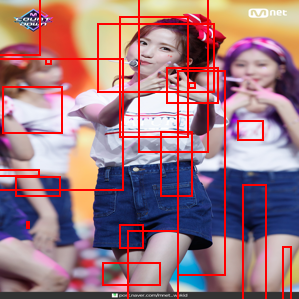

In [13]:
import random

allImages = [(member, imageName) for member in os.listdir(os.path.join(BASE_PATH, 'train')) for imageName in os.listdir(os.path.join(BASE_PATH, 'train', member))]
random.shuffle(allImages)

model = network()
model.load_weights(os.path.join(BASE_PATH, 'network4_yolo_highestMeanAccuracy.h5'))

imagesShown = 0
for (member, imageName) in allImages:
  if imagesShown >= 1:
    break

  print(member, imageName)
  fullPath = os.path.join(BASE_PATH, 'train', member, imageName)
  drawImage(fullPath, tf.reshape(model(np.array([load_img(fullPath)])), (13, 13, 2, 5)))

  imagesShown += 1

In [ ]:
# import functools

# data = {}

# with open(os.path.join(BASE_PATH, 'output.json')) as infile:
#     memfile = io.BytesIO()
#     memfile.write(json.load(infile).encode('latin-1'))
#     memfile.seek(0)
#     data = np.load(memfile, allow_pickle=True)[()] # See https://stackoverflow.com/questions/30811918/saving-dictionary-of-numpy-arrays/45661259

# accuracySum = 0
# for imagePath, imageEncoding in data.items():
#   print(imagePath)
#   accuracySum += yoloAccuracy(np.array([imageEncoding]), model(np.array([load_img(os.path.join(BASE_PATH, imagePath))])))

# print(accuracySum/len(data))